In [ ]:
"""

Purpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"
    and compare its performance to simple confidence thresholding on a logistic regression classifier.

Following https://builtin.com/data-science/guide-logistic-regression-tensorflow-20

--- Following Josh's placeholders_experiments.ipynb to create a version that works with text data

"""

'\n\nPurpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"\n    and compare its performance to simple confidence thresholding on a logistic regression classifier.\n\nFollowing https://builtin.com/data-science/guide-logistic-regression-tensorflow-20\n\n--- Following Josh\'s placeholders_experiments.ipynb to create a version that works with text data\n\n'

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tensorflow_addons as tfa
import tensorflow_probability as tfp
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import np_utils
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [3]:
NUM_CLASSES = 100

def load_dataset():
    df = pd.read_excel(r'/content/drive/MyDrive/NLP_Fall2022/Group Project/DatasetSplit/train_split.xlsx', usecols=['label','review'])
    df_test = pd.read_excel(r'/content/drive/MyDrive/NLP_Fall2022/Group Project/DatasetSplit/test_split.xlsx', usecols=['label','review'])


    X_train = df['review']
    y_train = df['label']
    X_test = df_test['review']
    y_test = df_test['label']
    return X_train, y_train, X_test, y_test

def validation_split(X, y, val_size=.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y)
    return X_train, X_val, y_train, y_val

In [4]:
X, y, X_test, y_test = load_dataset()

In [5]:
def plot_training_metric(train_values, val_values, metric_name):
    iterations = list(range(len(train_values)))
    plt.plot(iterations, train_values, label='Train')
    plt.plot(iterations, val_values, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title('{} While Training'.format(metric_name))
    plt.show()

In [6]:
class StandardLogisticRegressionModel(tf.keras.Model):
    def __init__(self, num_classes, pre_dim=200, post_dim=200, *args, **kwargs):
        super().__init__(*args, **kwargs)
        lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
        self.num_classes = num_classes
        self.embed_pre = tf.keras.layers.Dense(pre_dim, activation=lrelu, name='embed_pre')
        self.embed_post = tf.keras.layers.Dense(post_dim, activation=lrelu, name='embed_post')
        self.logits_layer = tf.keras.layers.Dense(num_classes, activation=None, name='ligits')
        self.output_layer = tf.keras.layers.Softmax(name='output')
        
    def call(self, inputs):
        x_pre = self.embed_pre(inputs)
        x_post = self.embed_post(x_pre)
        logits = self.logits_layer(x_post)
        return self.output_layer(logits)

def ce_loss(y_true, y_pred):
    """ Cross Entropy Loss.
    y_true: one-hot encoded class labels
    y_pred: class probabilities
    """
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def accuracy(y_true, y_pred):
    """y_true is the true class labels (not one-hot encoded) and y_pred are the predicted
    class labels (not class probabilities).
    """
    correct_preds = tf.equal(tf.cast(y_true, tf.int64), y_pred)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))

def train_SLRM(X, y, num_classes, epochs=25, plot=True, **kwargs):
    batch_size = 64
    vectorizer = TfidfVectorizer(max_features=250, sublinear_tf=True, ngram_range=(1,2))
    train_features = vectorizer.fit_transform(X_train).toarray()
    dev_features = vectorizer.transform(X_val).toarray()
    # y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=100)
    lb = LabelEncoder()
    ytrain = lb.fit_transform(y_train)
    dummy_y_train = np_utils.to_categorical(ytrain)

    yval = lb.fit_transform(y_val)
    dummy_y_dev = np_utils.to_categorical(yval)

    model = StandardLogisticRegressionModel( 
        num_classes=num_classes,
        **kwargs
    )
    model.compile(
        optimizer='adam', 
        loss=ce_loss, 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes, average='macro')]
    )
    y_train_one_hot = tf.one_hot(tf.cast(y, tf.int64), depth=model.num_classes)
    checkpoint_filepath = './tmp/checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    history = model.fit(
        train_features, dummy_y_train, epochs=epochs, 
        callbacks=[model_checkpoint_callback], validation_data=(dev_features, dummy_y_dev)
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['loss'], history['val_loss'], 'Loss')
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
    return model

Epoch 1/15
1114/1114 [==============================] - 11s 9ms/step - loss: 2.9778 - f1: 0.2857 - val_loss: 2.2039 - val_f1: 0.4417
Epoch 2/15
1114/1114 [==============================] - 6s 6ms/step - loss: 1.9288 - f1: 0.5056 - val_loss: 1.8544 - val_f1: 0.5285
Epoch 3/15
1114/1114 [==============================] - 6s 6ms/step - loss: 1.6495 - f1: 0.5727 - val_loss: 1.7056 - val_f1: 0.5654
Epoch 4/15
1114/1114 [==============================] - 6s 6ms/step - loss: 1.4817 - f1: 0.6140 - val_loss: 1.6381 - val_f1: 0.5770
Epoch 5/15
1114/1114 [==============================] - 6s 5ms/step - loss: 1.3605 - f1: 0.6396 - val_loss: 1.5748 - val_f1: 0.5894
Epoch 6/15
1114/1114 [==============================] - 8s 7ms/step - loss: 1.2651 - f1: 0.6639 - val_loss: 1.5486 - val_f1: 0.5986
Epoch 7/15
1114/1114 [==============================] - 6s 6ms/step - loss: 1.1772 - f1: 0.6839 - val_loss: 1.5329 - val_f1: 0.6068
Epoch 8/15
1114/1114 [==============================] - 6s 5ms/step - loss:

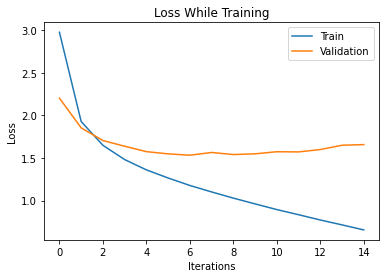

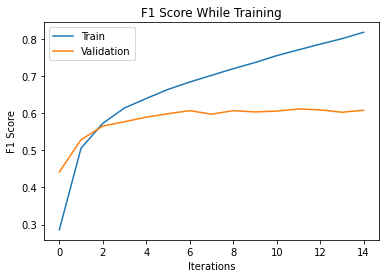

In [7]:
X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.2)
model = train_SLRM(X, y, num_classes=NUM_CLASSES, epochs=15, plot=True, pre_dim=250, post_dim=250)

In [27]:
""" 
Now we attempt open-set classicfication by training a logistic regression model on k 
classes (digits 0-8 for this dataset) and test on k+1. If all predicted class probabilities
are below a threshold, predict the open set.
"""
from itertools import compress
    
def threshold_predict(X, model, threshold):
    y_pred = model.call(X)
    highest_prob = tf.reduce_max(y_pred, axis=1)
    return tf.where(highest_prob < threshold, -1, tf.argmax(y_pred, axis=1))

def remove_classes_from_dataset(X, y, class_labels):
    """Removes samples from both X and y that correspond to classes given in class_labels
    class_labels: list of class_labels e.g. [3,4,9]
    y: tensor containing class labels (not yet one-hot encoded)
    """
    to_remove_mask = [y != label for label in class_labels]
    X = np.array(X) 
    result = X[to_remove_mask] 
    X=result.tolist()
    y = np.array(y) 
    result = y[to_remove_mask] 
    y=result.tolist()
    return X, y

def modify_open_set_labels(y, open_set_class_labels):
    """Replaces class labels from the open set in y with -1
    """
    open_set_idx = tf.reduce_any([y == label for label in open_set_class_labels], axis=0)
    return tf.where(open_set_idx, -1, y)

def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

def closed_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    closed_set_idx = y_true != -1
    return accuracy(y_true[closed_set_idx], y_pred[closed_set_idx])
    #return tf.reduce_sum(tf.equal(y_true[closed_set_idx], y_pred[closed_set_idx]))
def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

def open_set_f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    y_true = tf.where(y_true == -1, 1, 0)
    y_pred = tf.where(y_pred == -1, 1, 0)
    return f1_score(y_true, y_pred)
    
def known_fraction(y_pred):
    """Fraction of predicted class labels != -1"""
    return tf.reduce_sum(tf.cast(y_pred != -1, tf.int64)) / y_pred.shape

In [9]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
# X, y, X_test, y_test = load_dataset()
open_set_class_labels = [99] 

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)
X_val_closed, y_val_closed = remove_classes_from_dataset(X_val, y_val, open_set_class_labels)



pre_dim = post_dim = 200
model = StandardLogisticRegressionModel(pre_dim, post_dim, NUM_CLASSES - 1)
model.compile(optimizer='adam', loss=ce_loss, metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc')])





vectorizer = TfidfVectorizer(max_features=250, sublinear_tf=True, ngram_range=(1,2))
train_features = vectorizer.fit_transform(X_train_closed).toarray()
dev_features = vectorizer.transform(X_val_closed).toarray()

lb = LabelEncoder()
ytrain = lb.fit_transform(y_train_closed)
dummy_y_train = np_utils.to_categorical(ytrain)

yval = lb.fit_transform(y_val_closed)
dummy_y_dev = np_utils.to_categorical(yval)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1/15
1102/1102 [==============================] - 6s 5ms/step - loss: 2.9841 - f1: 0.2876 - val_loss: 2.2061 - val_f1: 0.4328
Epoch 2/15
1102/1102 [==============================] - 7s 6ms/step - loss: 1.9338 - f1: 0.5049 - val_loss: 1.8447 - val_f1: 0.5354
Epoch 3/15
1102/1102 [==============================] - 8s 7ms/step - loss: 1.6430 - f1: 0.5745 - val_loss: 1.7034 - val_f1: 0.5644
Epoch 4/15
1102/1102 [==============================] - 6s 6ms/step - loss: 1.4719 - f1: 0.6135 - val_loss: 1.6197 - val_f1: 0.5816
Epoch 5/15
1102/1102 [==============================] - 6s 5ms/step - loss: 1.3515 - f1: 0.6436 - val_loss: 1.5997 - val_f1: 0.5902
Epoch 6/15
1102/1102 [==============================] - 7s 6ms/step - loss: 1.2556 - f1: 0.6649 - val_loss: 1.5958 - val_f1: 0.5856
Epoch 7/15
1102/1102 [==============================] - 7s 6ms/step - loss: 1.1707 - f1: 0.6856 - val_loss: 1.5635 - val_f1: 0.6032
Epoch 8/15
1102/1102 [==============================] - 8s 8ms/step - loss: 

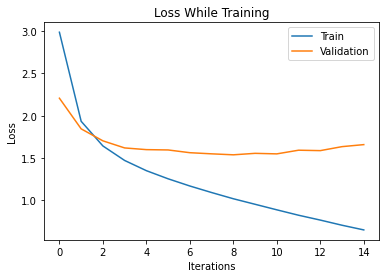

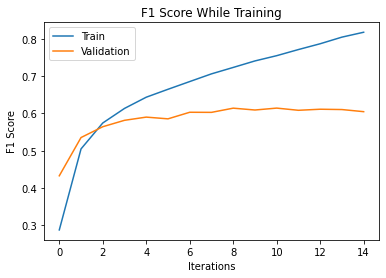

In [10]:
model = StandardLogisticRegressionModel( 
        num_classes=NUM_CLASSES-1,
        pre_dim=250, post_dim=250
)
model.compile(
  optimizer='adam', 
  loss=ce_loss, 
  metrics=[tfa.metrics.F1Score(name='f1', num_classes=NUM_CLASSES-1, average='macro')]
)

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_f1',
    mode='max',
    save_best_only=True
)
history = model.fit(
        train_features, dummy_y_train, epochs=15, 
        callbacks=[model_checkpoint_callback], validation_data=(dev_features, dummy_y_dev)
)
model.load_weights(checkpoint_filepath)
# if plot:
history = history.history
plot_training_metric(history['loss'], history['val_loss'], 'Loss')
plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')

In [22]:
def tune_model_param(model, val_closed, val_open, param_values, param_name, predict_func,
                     objective_func, target_value, objective_name, metrics, plot=True):
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val, open_set_class_labels)
    best_objective_error = float('inf')
    best_param_value = 0
    objective_values = []
    metric_values = {metric: [] for metric in metrics}
    for param_value in param_values:
        y_pred_closed = predict_func(val_closed['X'], model, param_value)
        y_pred_open = predict_func(val_open['X'], model, param_value)


        objective_values.append(objective_func(y_pred_closed))
        objective_error = float(abs(objective_values[-1] - target_value))
        if objective_error < best_objective_error:
            best_objective_error = objective_error
            best_param_value = param_value
        for metric in metrics:
            metric_values[metric].append(metrics[metric](val_open['y'], y_pred_open))
    if plot:
        for metric in metrics:
            plt.plot(param_values, metric_values[metric], label=metric)
        plt.plot(param_values, objective_values, label=objective_name)
        plt.xlabel(param_name)
        plt.legend()
        plt.title('Calibrating {}'.format(param_name))
        plt.show()
    return best_param_value

In [15]:
# See how the threshold value affects accuracy and find the threshold
# such that 95% of validation data is recognized as known

tuning_metrics = {
    'All Class F1': lambda *x: f1_score(*x, average='macro'),
    'Open-Set F1': open_set_f1_score,
    'All Class Accuracy': accuracy,
    'Open-Set Accuracy': open_set_accuracy,    
}

def tune_TSLR_threshold(model, X_val, y_val, open_set_class_labels, plot=True):
    """Tunes a Thresholded-Standard-Logistic-Regression model's threshold so
    that 95% of a closed-set validation set's samples are predicted to be
    from one of the known classes.
    """
    threshold_values = np.linspace(0, 1, 100)
    target_known_fraction = .95
    # split validation set into an open validation set and a closed validation set
    X_val_open, X_val_closed, y_val_open, y_val_closed = validation_split(X_val, y_val, val_size=.5)
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val_open, open_set_class_labels)
    # remove open-set samples from the closed-set validation data
    X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, open_set_class_labels)

    X_val_open_features = vectorizer.fit_transform(X_val_open).toarray()
    X_val_closed_features = vectorizer.fit_transform(X_val_closed).toarray()

    val_closed = {'X': X_val_closed_features, 'y': y_val_closed}
    val_open = {'X': X_val_open_features, 'y': y_val_open}
    param_name = 'Classification Probability Threshold'
    objective_name = 'Known Fraction'
    threshold = tune_model_param(
        model, val_closed, val_open, threshold_values, param_name, threshold_predict,
        known_fraction, target_known_fraction, objective_name, tuning_metrics, plot=plot
    )
    return threshold

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


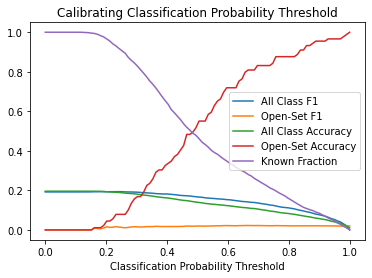

Results from test set using 95% threshold (0.2121):
All Class F1: 0.1552
Open-Set F1: 0.0000
All Class Accuracy: 0.1584
Open-Set Accuracy: 0.0000


In [28]:
threshold = tune_TSLR_threshold(model, X_val, y_val, open_set_class_labels)

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)


test_features = vectorizer.fit_transform(X_test).toarray()
y_pred = threshold_predict(test_features, model, threshold)
print('Results from test set using 95% threshold ({:.4f}):'.format(threshold))
for metric in tuning_metrics:
    metric_func = tuning_metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

In [39]:
""" Now that we have a baseline, we will implement the placeholders algorithm.
"""

class OpenSetPlaceholdersLRM(StandardLogisticRegressionModel):
    def __init__(self, num_placeholders, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_placeholders = num_placeholders
        self.dummy_logits_layer = tf.keras.layers.Dense(num_placeholders, activation=None, name='dummy_logits')
        self.bias = 0 # used to calibrate dummy logit to have same magnitude as rest of logits

    def _pre(self, inputs):
        return self.embed_pre(inputs)
    
    def _rest(self, inputs):
        x_post = self.embed_post(inputs)
        closed_set_logits = self.logits_layer(x_post)
        dummy_logits = self.dummy_logits_layer(x_post)
        max_dummy_logit = tf.reduce_max(dummy_logits, axis=1)
        all_logits = tf.concat([closed_set_logits, tf.expand_dims(max_dummy_logit, 1) + self.bias], axis=1)
        return self.output_layer(all_logits)
        
    def call(self, inputs):
        x_pre = self._pre(inputs)
        return self._rest(x_pre)
        
    def predict(self, x):
        """ Returns the predicted class label. If predicted class is dummy class, return -1
        indicating prediction falls within the open set.
        """
        y_pred = self.call(x)
        y_pred_labels = tf.argmax(y_pred, axis=1)
        return tf.where(y_pred_labels == self.num_classes, -1, y_pred_labels)    
    
def ce_loss_for_placeholders(y_true, y_pred, beta):
    loss = ce_loss(y_true, y_pred)
    # set each sample's predicted probability for the true class to zero
    y_pred_without_true_prob = tf.where(y_true == 1, 0., y_pred)
    # create a new y_true where the true label is the dummy class
    rows, cols = y_true.shape
    rows = rows or 1
    y_true_dummy = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
    loss += beta * ce_loss(y_true_dummy, y_pred_without_true_prob)
    return loss



In [31]:

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)
X_val_closed, y_val_closed = remove_classes_from_dataset(X_val, y_val, open_set_class_labels)


# The "+ 1"s below add an additional column of zeros to the one-hot encodings for
# the dummy class
train_features = vectorizer.fit_transform(X_train_closed).toarray()
dev_features = vectorizer.transform(X_val_closed).toarray()


y_train_one_hot = tf.one_hot(y_train_closed, depth=model.num_classes + 1)
y_val_one_hot = tf.one_hot(y_val_closed, depth=model.num_classes + 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1/15
552/552 [==============================] - 3s 4ms/step - loss: 5.7945 - f1: 5.4645e-05 - val_loss: 5.2361 - val_f1: 1.7241e-04
Epoch 2/15
552/552 [==============================] - 2s 4ms/step - loss: 4.7579 - f1: 0.0140 - val_loss: 4.3782 - val_f1: 0.0389
Epoch 3/15
552/552 [==============================] - 2s 4ms/step - loss: 4.1456 - f1: 0.0742 - val_loss: 4.0118 - val_f1: 0.1106
Epoch 4/15
552/552 [==============================] - 2s 4ms/step - loss: 3.8446 - f1: 0.1382 - val_loss: 3.7973 - val_f1: 0.1575
Epoch 5/15
552/552 [==============================] - 2s 4ms/step - loss: 3.6673 - f1: 0.1848 - val_loss: 3.6784 - val_f1: 0.2030
Epoch 6/15
552/552 [==============================] - 2s 4ms/step - loss: 3.5501 - f1: 0.2165 - val_loss: 3.5963 - val_f1: 0.1992
Epoch 7/15
552/552 [==============================] - 2s 4ms/step - loss: 3.4654 - f1: 0.2392 - val_loss: 3.5334 - val_f1: 0.2257
Epoch 8/15
552/552 [==============================] - 2s 4ms/step - loss: 3.3945 -

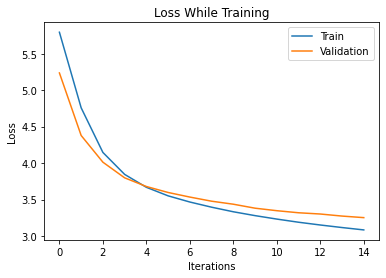

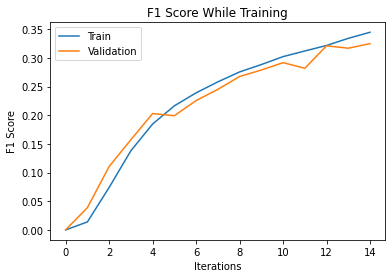

In [34]:


open_set_class_labels = [99] 



num_placeholders = 120
pre_dim = post_dim = 200

beta = .75
model = OpenSetPlaceholdersLRM(
        num_classes=NUM_CLASSES-1,
        num_placeholders=20,
        pre_dim=50,
        post_dim=50
)
loss = lambda *x: ce_loss_for_placeholders(*x, beta)
model.compile(
        optimizer='adam', 
        loss=loss, 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=NUM_CLASSES-1+1, average='macro')]
)



es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history=model.fit(train_features, y_train_one_hot, batch_size=64,
                  callbacks=[es_callback],
          epochs=15, validation_data=(dev_features, y_val_one_hot))


# y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes + 1)
# history = model.fit(X_train_closed, y_train_one_hot, epochs=20, validation_split=.2, batch_size=32)

history = history.history
plot_training_metric(history['loss'], history['val_loss'], 'Loss')
plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')

In [37]:
# See how the bias value affects accuracy and find the bias
# such that 95% of validation data is recognized as known

def tune_OSPLRM_threshold(model, X_val, y_val, open_set_class_labels, plot=True):
    """Tunes a Open-Set-Placeholders-Logistic-Regression model's bias so
    that 95% of a closed-set validation set's samples are predicted to be
    from one of the known classes.
    """
    def placeholders_predict(X, model, bias):
        model.bias = bias
        return model.predict(X)

    target_known_fraction = .95
    bias_values = np.linspace(-2, 2, 100)
    # split validation set into an open validation set and a closed validation set
    X_val_open, X_val_closed, y_val_open, y_val_closed = validation_split(X_val, y_val, val_size=.5)
    # convert instances of class labels in the open set to -1
    y_val_open = modify_open_set_labels(y_val_open, open_set_class_labels)
    # remove open-set samples from the closed-set validation data
    X_val_closed, y_val_closed = remove_classes_from_dataset(X_val_closed, y_val_closed, open_set_class_labels)


    X_val_open_features = vectorizer.fit_transform(X_val_open).toarray()
    X_val_closed_features = vectorizer.fit_transform(X_val_closed).toarray()


    val_closed = {'X': X_val_closed_features, 'y': y_val_closed}
    val_open = {'X': X_val_open_features, 'y': y_val_open}
    param_name = 'Dummy Classifier Bias'
    objective_name = 'Known Fraction'
    bias = tune_model_param(
        model, val_closed, val_open, bias_values, param_name, placeholders_predict,
        known_fraction, target_known_fraction, objective_name, tuning_metrics, plot=plot
    )
    return bias

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


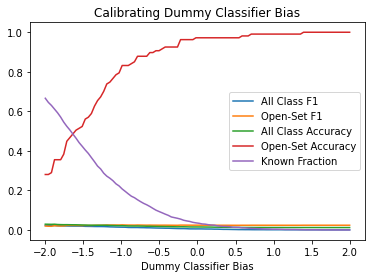

Results from test set using 95% bias (-2.0000):
All Class F1: 0.0535
Open-Set F1: 0.0249
All Class Accuracy: 0.0552
Open-Set Accuracy: 0.4348


In [38]:
bias = tune_OSPLRM_threshold(model, X_val, y_val, open_set_class_labels)
model.bias = bias

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)

test_features = vectorizer.fit_transform(X_test).toarray()
y_pred = model.predict(test_features)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in tuning_metrics:
    metric_func = tuning_metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))

In [49]:


NUM_FEATURES = 1784

"""We will now introduce data placeholders. In essence, we will be synthesizing open-set training
data via a process called "manifold mixup". We will also introduce a new loss function which makes
use of the new synthetic data.
"""

# Open set placeholder
class OSPWithDataPlaceholdersLRM(OpenSetPlaceholdersLRM):
    def __init__(self, alpha, beta, gamma, *args, **kwargs):
        x = tf.keras.layers.Input(shape=(NUM_FEATURES,), batch_size=64)
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
    def train_step(self, data):
        X, y = data
        X_part1, X_part2 = tf.split(X, 2)
        y_part1, y_part2 = tf.split(y, 2)
        # create a new y_true where the true label is the open-set class
        rows, cols = y_part2.shape
        rows = rows or 1
        y_part2_new = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
        
        with tf.GradientTape() as tape:
            # caldulate the first portion of the loss on the first half of the batch
            y_part1_pred = self.call(X_part1)
            loss1 = ce_loss_for_placeholders(y_part1, y_part1_pred, self.beta)
            # perform manifold mixup and calculate the second part of the loss
            X_part2_pre = self._pre(X_part2)
            X_part2_pre_hat = self.manifold_mixup(X_part2_pre)
            y_part2_pred = self._rest(X_part2_pre_hat)
            loss2 = ce_loss(y_part2_new, y_part2_pred)
            # calculated weighted sum of losses
            loss = loss1 + self.gamma * loss2
            
        # compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics using the predictions from batch part 1
        self.compiled_metrics.update_state(y_part1, y_part1_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def manifold_mixup(self, X_pre):
        """
        """
        alpha = tf.constant(self.alpha)
        dist = tfp.distributions.Beta(alpha, alpha)
        lam = dist.sample(1)
        if not X_pre.shape[0]:
            return X_pre
        indices = tf.random.shuffle(tf.range(X_pre.shape[0]))
        X_pre_hat = lam * X_pre + (1 - lam) * tf.gather(X_pre, indices)
        return X_pre_hat

def train_OSPWDPLSM(X, y, num_classes, batch_size=64, epochs=25, plot=True, **kwargs):
    model = OSPWithDataPlaceholdersLRM(
        num_classes=num_classes,
        **kwargs
    )
    model.compile(
        optimizer='adam', 
        metrics=[tfa.metrics.F1Score(name='f1', num_classes=num_classes+1, average='macro')]
    )
    # The "+ 1"s below add an additional column of zeros to the one-hot encodings for
    # the dummy class
    y_train_one_hot = tf.one_hot(tf.cast(y_train_closed, tf.int64), depth=model.num_classes + 1)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_f1',
        mode='max',
        save_best_only=True
    )
    X_train, X_val, y_train, y_val = validation_split(X, y_train_closed, .2)
    # ensure the length of the training dataset is a multiple of the batch_size

    y_train = tf.one_hot(tf.cast(y_train, tf.int64), depth=model.num_classes + 1)
    y_val = tf.one_hot(tf.cast(y_val, tf.int64), depth=model.num_classes + 1)

    vectorizer = TfidfVectorizer(max_features=250, sublinear_tf=True, ngram_range=(1,2))
    X_train = vectorizer.fit_transform(X_train).toarray()
    X_val = vectorizer.transform(X_val).toarray()

    num_train_samples = (X_train.shape[0] // batch_size) * batch_size
    X_train = X_train[:num_train_samples]
    y_train = y_train[:num_train_samples]
    history = model.fit(
        X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=batch_size,
        callbacks=[model_checkpoint_callback]
    )
    model.load_weights(checkpoint_filepath)
    if plot:
        history = history.history
        plot_training_metric(history['f1'], history['val_f1'], 'F1 Score')
    return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1/35
413/413 [==============================] - 3s 4ms/step - f1: 0.0000e+00 - val_loss: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/35
413/413 [==============================] - 2s 4ms/step - f1: 0.0000e+00 - val_loss: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/35
413/413 [==============================] - 2s 4ms/step - f1: 0.0097 - val_loss: 0.0000e+00 - val_f1: 0.0173
Epoch 4/35
413/413 [==============================] - 2s 4ms/step - f1: 0.0338 - val_loss: 0.0000e+00 - val_f1: 0.0469
Epoch 5/35
413/413 [==============================] - 2s 4ms/step - f1: 0.0661 - val_loss: 0.0000e+00 - val_f1: 0.0764
Epoch 6/35
413/413 [==============================] - 2s 6ms/step - f1: 0.0979 - val_loss: 0.0000e+00 - val_f1: 0.1167
Epoch 7/35
413/413 [==============================] - 2s 6ms/step - f1: 0.1286 - val_loss: 0.0000e+00 - val_f1: 0.1354
Epoch 8/35
413/413 [==============================] - 2s 5ms/step - f1: 0.1548 - val_loss: 0.0000e+00 - val_f1: 0.1527
Epoch 9/35
413/413 [============

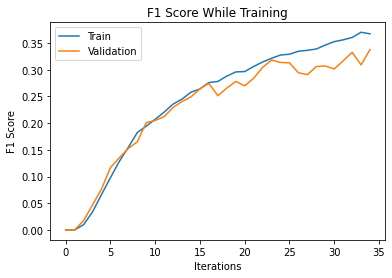

In [50]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [99] 

X_train, X_val, y_train, y_val = validation_split(X, y, val_size=.3)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

model = train_OSPWDPLSM(
    X_train_closed, y_train_closed,
    num_classes=NUM_CLASSES-1,
    epochs=35,
    num_placeholders=20,
    pre_dim=50,
    post_dim=50,
    alpha=2.0,
    beta=.7,
    gamma=.2,
    plot=True,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


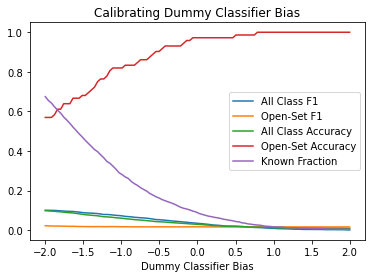

Results from test set using 95% bias (-2.0000):
All Class F1: 0.0514
Open-Set F1: 0.0203
All Class Accuracy: 0.0524
Open-Set Accuracy: 0.5217


In [52]:
bias = tune_OSPLRM_threshold(model, X_val, y_val, open_set_class_labels)
model.bias = bias

# Evaluate on test set

# convert instances of class labels in the open set to -1
y_test_open = modify_open_set_labels(y_test, open_set_class_labels)

test_features = vectorizer.fit_transform(X_test).toarray()
y_pred = model.predict(test_features)
print('Results from test set using 95% bias ({:.4f}):'.format(bias))
for metric in tuning_metrics:
    metric_func = tuning_metrics[metric]
    print('{}: {:.4f}'.format(metric, metric_func(y_test_open, y_pred)))